# Getting Started with AstroBkgInterp: JWST/MIRI Medium Resolution Spectrometry Example

This notebook presents an analysis of JWST MIRI Medium Resolution Spectrograph (MRS) data from the JWST [Program 1860](https://www.stsci.edu/jwst/science-execution/program-information?id=1860) (PI: Fox), specifically focusing on the Type IIn supernova 2005ip. This tutorial offers a detailed, step-by-step guide for estimating and subtracting backgrounds using the AstroBkgInterp package. By the end of this notebook, you will gain hands-on experience with the tools and techniques provided by AstroBkgInterp. This knowledge will enable you to apply the package to similar datasets, whether they are 2D or 3D, or obtained from other instruments or telescopes.

<div class="alert alert-warning"> 
    **Prerequisite**: The final section of this notebook ([4.](#results)) involves running the [JWST Calibration Pipeline](https://github.com/spacetelescope/jwst), which requires the `jwst` package. If you do not have this package installed (*Note*: `jwst` is not a requirement for `AstroBkgInterp` and is not included in the default conda environment), you can install it using the command `pip install jwst`. Alternatively, you can skip this part of the notebook if you prefer.
</div>

## Contents
1. [Introduction](#intro)<br>
    1.1. [Package Imports](#imports)<br>
    1.2. [Setup](#setup)<br>
2. [Source-Masking](#source-masking)<br>
    2.1. [Locate the source using `Photutils`](#loc)<br>
    2.2. [Set the aperture and annulus sizes](#set) <br>
    2.3. [Verify the source-masking](#verify) <br>
3. [Background Modelling](#bkg) <br>
    3.1. [Estimate and subtract the background](#run) <br>
4. [Optional: Final Spectrum Extraction](#results) <br>
    4.1. [Pipeline Imports](#jwstimports)<br>
    4.2. [Run `Extract1d` on the background subtracted data](#extract1d)<br>
    4.3. [Inspect the final spectrum](#plot)<br>
    4.4. [Compare with the default pipeline extraction](#compare)<br>


<a id="intro"></a>
## Introduction 
Core-collapse supernovae (CCSNe) are critical probes of massive stellar evolution and chemical enrichment in galaxies. However, they are often embedded in crowded or high surface-brightness regions of their host galaxies, where background emission is spatially structured and varies on small angular scales. In such environments, accurate background estimation is essential for isolating the supernova signal and deriving reliable photometry and spectra. 

This notebook analyzes observations of the Type IIn Supernova 2005ip captured 17 years post-explosion by [Shahbandeh et al. 2024](https://doi.org/10.48550/arXiv.2410.09142). For 2005ip, the global thermal background is roughly 10 to 40 times larger than the Supernova (SN) itself, making local background estimation both critical and challenging. Even small variability in the background across the field of view (FOV) can have a potentially significant impact on the source spectrum. This is particularly true at the longer wavelengths, where thermal background tends to dominate, and the intrinsic SN signal is weakest.

To address this, we will use `AstroBkgInterp` to perform accurate, spatially resolved background subtraction tailored to the complex environment of SN 2005ip. First, we will apply its source-masking procedure to exclude the SN flux and replace it with an interpolated estimate of the underlying background. Then, we will use `AstroBkgInterp` to fit a global background model to the masked data and subtract it from the original data. This approach will improve the fidelity of the extracted spectrum, particularly in the background-dominated mid-infrared regime, enabling the detection of faint dust emission features and yielding more robust constraints on the cold dust mass. 

<a id="imports"></a>
### Import Packages

- `AstroBkgInterp` is our background estimation tool
- `numpy` for array processing and math
- `atropy.io` for accessing the data
- `astropy.time` for timing
- `astropy.stats` for calculating statistics on the data
- `matplotlib` for plotting images and spectra
- `photutils.detection` for finding sources in the data
  
*Optional*:
- `jwst` for running the pipeline

In [1]:
import copy
import os

# Import the background subtraction tool 
from AstroBkgInterp import AstroBkgInterp

# Import astropy packages
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
import astropy.units as u

# Import packages for displaying images in notebook
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For data handling
import numpy as np

# To find stars in the MRS spectralcubes 
from photutils.detection import DAOStarFinder

<a id="setup"></a>
### Setup

#### Set path to Data
For this notebook, we will analyze a JWST/MIRI MRS Level 3 spectral cube that combines all four channels (Ch1-4) and their sub-bands (short, medium, long), giving the full 5-28 μm 3D IFU cube for the target. 

In [2]:
data_url = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_MRS_bkg_notebook/Level3_ch1-2-3-4-shortmediumlong_s3d.fits"

#### Open and display the data 

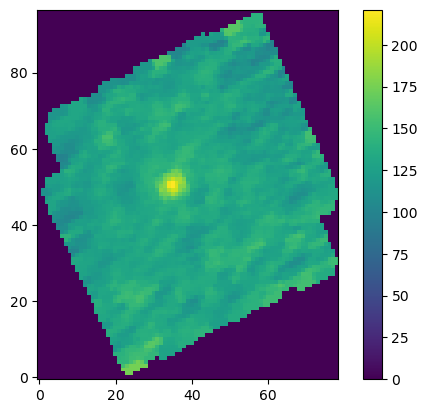

In [3]:
hdu = fits.open(data_url)
data = hdu[1].data

# set all NaN values to 0
data[np.isnan(data)] = 0

plt.imshow(data[9000], origin='lower')
plt.colorbar()

<a id="source-masking"></a>
## Source-Masking Procedure

A critical feature of `AstroBkgInterp` is its ability to exclude flux from astrophysical sources during the background estimation process. It implements a flexible and configurable source-masking routine that enables users to define regions of interest (typically containing one or more sources) to be excluded from the final background model. 

The user defines the position of the target source, along with an aperture geometry and size; both circular and elliptical apertures are supported. These apertures define the region to be masked and replaced with an interpolated estimate of the underlying background. In polar coordinates centered on the source, the algorithm computes the median flux at each angle from the surrounding annulus and interpolates across the masked region. This directionally informed approach preserves local background structure while excluding contamination from the source itself. To increase robustness and minimize interpolation artifacts, the procedure is repeated in a grid of eight dithered positions surrounding the central source, and the resulting estimates are median-combined to produce the final background.

For 3D data cubes, `AstroBkgInterp` supports wavelength-dependent masking, allowing for the mask to vary as a function of wavelength. This capability accommodates the variation in PSF size with wavelength, and spectral variations in source morphology, ensuring accurate background estimation across the full spectral range.

<a id="loc"></a>
### 1) Locate the source using `Photutils` 

In order to utilize `AstroBkgInterp`'s source-masking algorithm, we first need to identify the position of the source. Rather than relying solely on the coordinates provided in the image header, we begin by identifying the brightest source in the data cube, which we assume to be the supernova (SN). To accomplish this, we use `DAOStarFinder`, an implementation of the DAOFIND algorithm [Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract) designed for point-source detection in astronomical images. DAOFIND locates local maxima in the image that exceed a specified `threshold` (applied to a convolved image) and have a size and shape similar to the defined 2D Gaussian kernel. 

**Note**: both the detection threshold and maximum separation allowed between neighboring sources should be adjusted based on the specific science case (e.g., the number of stars in the field, the degree of crowding, and the expected brightness distribution).

In [4]:
cube = np.zeros((data.shape[1], data.shape[2]))
for a in range(data.shape[1]):
    for b in range(data.shape[2]):
        cube[a, b] = np.median(data[:, a, b])

mean, median, std = sigma_clipped_stats(cube, sigma=3.0)

# Get a list of sources using a dedicated source detection algorithm
# Find sources at least 3* background (typically)

daofind = DAOStarFinder(fwhm=2.0, threshold=3.*std)
sources = daofind(cube-median) 
print("\n Number of sources in field:", len(sources))

# Positions in pixels
positions = Table([sources['xcentroid'], sources['ycentroid']])

# Convert to RA & Dec (ICRS)
peakpixval = np.zeros(len(sources['xcentroid']))

for count_s, _ in enumerate(sources):
    peakpixval[count_s] = cube[int(np.round(sources['xcentroid'][count_s])), int(np.round(sources['ycentroid'][count_s]))]

# Set the peak pixel positions as the source position. 
src_x, src_y = sources['xcentroid'][np.argmax(peakpixval)], sources['ycentroid'][np.argmax(peakpixval)]
print(f'peak pixel x = {src_x}')
print(f'peak pixel y = {src_y}')


 Number of sources in field: 1
peak pixel x = 35.26506068149835
peak pixel y = 50.14063878849061


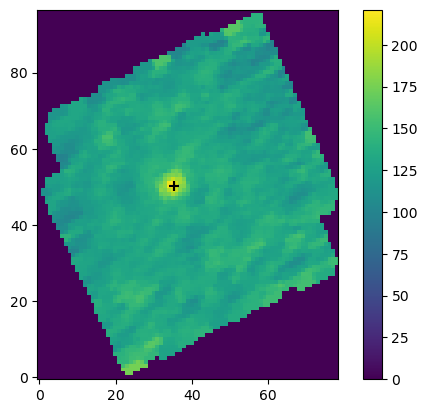

In [5]:
# Plot all of the sources
plt.imshow(data[9000], origin='lower')
plt.colorbar()
plt.scatter(sources['xcentroid'], sources['ycentroid'], c="red", marker="+", s=50)
plt.scatter(src_x, src_y, c="black", marker="+", s=50)

<a id="set"></a>
### 2) Set the aperture and annulus sizes

The next step is to define the aperture and annulus radii for the source-masking procedure. The aperture defines the region to be masked (i.e., the area occupied by the source), while the annulus provides the surrounding region from which the background underneath the source is estimated.

When selecting an aperture radius, the goal is to encompass as much of the source flux as possible, ensuring that the annulus lies beyond the majority of the source light. At the same time, the annulus should remain close enough to the source that the sampled background is representative of the local environment. The annulus must also be sufficiently wide to include enough pixels for a reliable statistical estimate of the underlying background.

#### Manual aperture definition

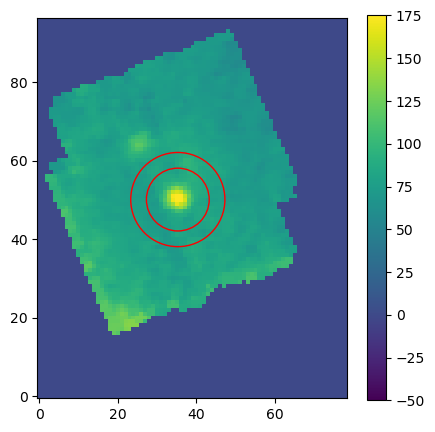

In [6]:
aper_rad = 8  
ann_width = 4

plt.figure(figsize=(5, 5))
plt.imshow(data[8000], vmin=-50, vmax=175, origin='lower')
plt.colorbar()

circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)
annin = Circle((src_x, src_y), radius=aper_rad+ann_width, color='r', fill=False)
plt.gca().add_patch(circ)
plt.gca().add_patch(annin)

#### Wavelength dependent masking

For 3D data cubes, `AstroBkgInterp` also supports wavelength-dependent masking, allowing the aperture radius to vary as a function of wavelength. This capability accommodates the variation in PSF size with wavelength, and spectral variations in source morphology, ensuring accurate background estimation across the full spectral range. 

To define an aperture mask size that appropriately encompasses the flux, users can base the aperture radius on the PSF FWHM. To do this, they will need to configure two parameters:

1. `fwhm`: the PSF FWHM array, i.e., an array matching the spectral dimension of the data cube, where each element corresponds to the PSF FWHM at that wavelength. This allows `AstroBkgInterp` to adjust the aperture size dynamically across the cube.
2. `fwhm_scale`: a constant scaling factor (default is 1.25) that multiplies the PSF FWHM to set the aperture radius. 

Together, these parameters will set the aperture radius to `fwhm_scale x fwhm` at each wavelength slice.

Below we will define the FWHM array using WCS parameters and `np.linspace`, and the linear fit to the MIRI PSF found in Figure 2 https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-operations/miri-dithering/miri-mrs-psf-and-dithering#gsc.tab=0.

In [8]:
# Extract wavelength array from WCS metadata table
WAVEfull = hdu[5].data['WAVELENGTH'][0]

# Get spatial pixel scale along x-axis from the WCS metadata (degrees/pixel)
hdr = hdu[1].header 
cdelt1 = hdr["CDELT1"] * u.deg

# Convert to arcsec/pix
cdelt1 = cdelt1.to(u.arcsec).value

# Compute angular PSF FWHM (θ) in arcsec as a function of wavelength.
# This uses an empirical model: θ(λ) = 0.033 * λ + 0.106, with λ in microns.
θ = 0.033 * WAVEfull + 0.106  

# Convert FWHM from arcsec to pixels
fwhm = θ / cdelt1  

# Set the FWHM scale
fwhm_scale = 1.5 # This will produce an aperture radius 1.25 times the local PSF FWHM.

Below, we compare the two aperture masking approaches across different slices of the cube: the top row shows the fixed-radius method that applies the same aperture size at all wavelengths, and the second row shows the wavelength-dependent method that dynamically adjusts the aperture size at each spectral slice based on the `fwhm` and `fwhm_scale` we set above. 

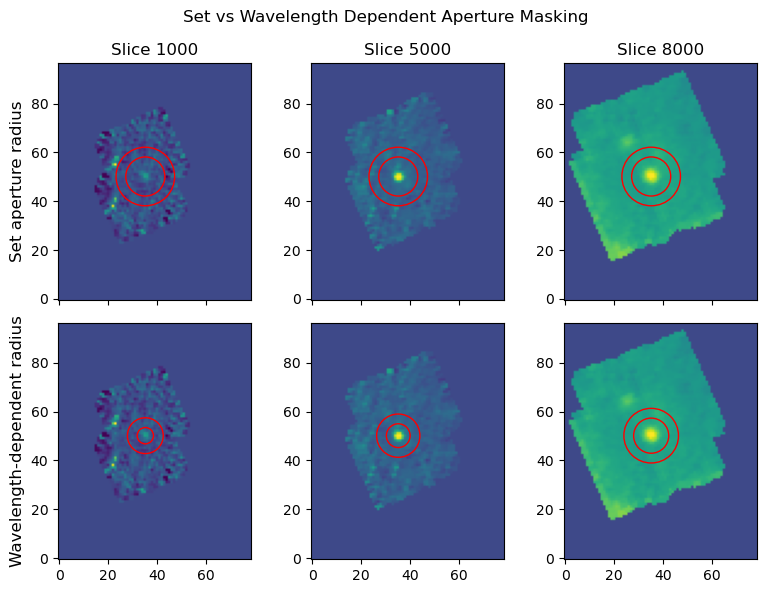

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6), sharex=True)

circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)

fig.suptitle('Set vs Wavelength Dependent Aperture Masking')

ax[0, 0].set_title('Slice 1000')
ax[0, 1].set_title('Slice 5000')
ax[0, 2].set_title('Slice 8000')
ax[0, 0].set_ylabel('Set aperture radius', fontsize=12)
ax[1, 0].set_ylabel('Wavelength-dependent radius', fontsize=12)

ax[0, 0].imshow(data[1000], vmin=-50, vmax=175, origin='lower')
circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)
annin = Circle((src_x, src_y), radius=aper_rad+ann_width, color='r', fill=False)
ax[0, 0].add_patch(circ)
ax[0, 0].add_patch(annin)

ax[0, 1].imshow(data[5000], vmin=-50, vmax=175, origin='lower')
circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)
annin = Circle((src_x, src_y), radius=aper_rad+ann_width, color='r', fill=False)
ax[0, 1].add_patch(circ)
ax[0, 1].add_patch(annin)

ax[0, 2].imshow(data[8000], vmin=-50, vmax=175, origin='lower')
circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)
annin = Circle((src_x, src_y), radius=aper_rad+ann_width, color='r', fill=False)
ax[0, 2].add_patch(circ)
ax[0, 2].add_patch(annin)

ax[1, 0].imshow(data[1000], vmin=-50, vmax=175, origin='lower')
aper_rad = fwhm_scale*fwhm[1000]
circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)
annin = Circle((src_x, src_y), radius=aper_rad+ann_width, color='r', fill=False)
ax[1, 0].add_patch(circ)
ax[1, 0].add_patch(annin)

ax[1, 1].imshow(data[5000], vmin=-50, vmax=175, origin='lower')
aper_rad = fwhm_scale*fwhm[5000]
circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)
annin = Circle((src_x, src_y), radius=aper_rad+ann_width, color='r', fill=False)
ax[1, 1].add_patch(circ)
ax[1, 1].add_patch(annin)

im = ax[1, 2].imshow(data[8000], vmin=-50, vmax=175,  origin='lower')
aper_rad = fwhm_scale*fwhm[8000]
circ = Circle((src_x, src_y), radius=aper_rad, color='r', fill=False)
annin = Circle((src_x, src_y), radius=aper_rad+ann_width, color='r', fill=False)
ax[1, 2].add_patch(circ)
ax[1, 2].add_patch(annin)

plt.tight_layout()

The above plot illustrates how applying a fixed aperture across the entire MIRI MRS data cube can result in both over-masking at some wavelengths and under-masking at others, ultimately compromising the quality of the background subtraction.

At shorter wavelengths (where the PSF is narrower), the fixed aperture may be too large, including excess background and potentially nearby sources. Conversely, at longer wavelengths (where the PSF is broader), the same aperture may be too small, missing significant portions of the source flux. This leaves residual source flux in the background model, contaminating the background estimate and under-subtracting the source. 

Using wavelength-dependent masking helps address these issues by ensuring the aperture appropriately scales with the PSF across the spectral range, leading to cleaner and more accurate background estimates.


<a id="verify"></a>
### 3) Verify the source-masking 

To verify the source masking and manually refine the aperture and annulus radii if needed, `AstroBkgInterp` can be run with `bkg_mode = None`. In this mode, the source-masking routine executes as usual, but the tool does not construct a spatial background model across the entire frame. The result is effectively a "source replacement" only, where the background is interpolated locally beneath each masked region without estimating or subtracting a broader background across the image.

In [10]:
bi = AstroBkgInterp()

# Source position
bi.src_y = src_y
bi.src_x = src_x

# Source masking params
bi.aper_rad = aper_rad
bi.ann_width = ann_width

bi.fwhm = fwhm
bi.fwhm_scale = 1.5

# Background params
bi.bkg_mode = 'None' 

# Multiprocessing params
bi.pool_size = 12 

diff, bkg, mask = bi.run(data)

Source Masking: circular
    Center: (np.float64(35.26506068149835), np.float64(50.14063878849061))
    Aperture radius: [7.19044006]
    Annulus width: 4
Background Mode: None
    v_wht_s, h_wht_s: (1.0, 1.0)
    Convolution: False
    combine_fits: False
    polynomial order: 3
    bin size: 5
    cube_resolution: high

Multiprocessing: True
    pool_size: 12

Uncertainties: False



Inspect the source masked data.

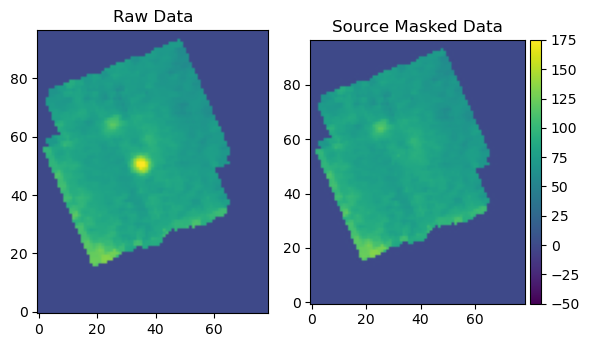

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharex=True)

ax[0].set_title('Raw Data')
ax[1].set_title('Source Masked Data')

a = ax[0].imshow(data[8000], vmin=-50, vmax=175, origin='lower', cmap='viridis')
b = ax[1].imshow(bkg[8000], vmin=-50, vmax=175, origin='lower', cmap='viridis')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(b, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

Once we are happy with the source masking, we can move on to the background modelling stage.

<a id="bkg"></a>
## Background Modelling

In addition to localized source masking, `AstroBkgInterp` provides robust background modelling capabilities designed to handle spatially complex astrophysical sources. After masking flux in the user-defined source regions, the tool constructs a background model using one of several configurable fitting methods. These include a fast, one-dimensional row/column median estimator (`bkg_mode = simple`) and a more sophisticated two-dimensional polynomial surface fitting approach (`bkg_mode = polynomial`). The background model is generated from the source-masked image and is applied on a per-frame basis for 2D images, and on a per-slice basis for 3D data cubes. 

<a id="run"></a>
### 4) Estimate and subtract the background

For the purpose of this notebook, we will set the `"polynomial"` background mode. This mode constructs a background model using a 2D polynomial surface fitting approach implemented in a sliding-window framework. The image is subdivided into a series of overlapping subregions, and a low-order polynomial is independently fit to each region. These fits are then median combined at each pixel location, effectively mitigating the influence of outliers, cosmic rays, and localized noise features. The result is a smooth and robust background model that preserves large-scale background structure while expressing small-scale fluctuations. 

We set the following parameters to control the behavior and resolution of the polynomial fitting process:

- `k`: Specifies the degree of the 2D polynomial used for each local fit. Higher values allow for greater flexibility in modeling complex background structure but may increase the risk of overfitting. We adopt the default value of `k = 3`, which provides a good balance between smoothness and adaptability.

- `bin_size`: Defines the size of the subregions (windows) over which the local polynomial fitting is performed. Smaller windows capture finer spatial variations but increase computational cost, while larger windows produce smoother fits at the expense of resolving small-scale structure. For this work, we use a bin size of `5`.

- `cube_resolution`: Controls the spatial sampling and density of polynomial fits across the image. It determines both the number of local fits and the step size between successive fitting regions. We set `cube_resolution = high`, which enforces the finest sampling, yielding a smoother and more detailed background model at the cost of increased computation time.

In [ ]:
bi = AstroBkgInterp()

# Source position
bi.src_y = src_y
bi.src_x = src_x

# Source masking params
bi.aper_rad = aper_rad
bi.ann_width = ann_width

bi.fwhm = fwhm
bi.fwhm_scale = 1.5

# Background params
bi.bkg_mode = 'polynomial' 
bi.k = 3 
bi.bin_size = 9 
bi.cube_resolution = 'high' 

# Multiprocessing params
bi.pool_size = 12 

diff, bkg, mask = bi.run(data)

Source Masking: circular
    Center: (np.float64(35.26506068149835), np.float64(50.14063878849061))
    Aperture radius: [7.19044006]
    Annulus width: 4
Background Mode: polynomial
    v_wht_s, h_wht_s: (1.0, 1.0)
    Convolution: False
    combine_fits: False
    polynomial order: 3
    bin size: 9
    cube_resolution: high

Multiprocessing: True
    pool_size: 12

Uncertainties: False



Save out new background subtracted data.

In [ ]:
newdata = np.array([s for s in diff])
newhdu = copy.deepcopy(hdu)
newhdu[1].data = newdata
newhdu.writeto('newdata_high_res.fits', overwrite=True)

Now lets plot out all the products returned by `AstroBkgInterp`.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 12))

ax[0, 0].set_title('Raw Data')
ax[0, 1].set_title('Source-Masked data')
ax[1, 0].set_title('Background Fit')
ax[1, 1].set_title('Residual')

a = ax[0, 0].imshow(data[8000], vmin=-10, vmax=180, origin='lower')
b = ax[0, 1].imshow(mask[8000][0], vmin=-10, vmax=180, origin='lower')
c = ax[1, 0].imshow(bkg[8000], vmin=-10, vmax=180, origin='lower')
d = ax[1, 1].imshow(diff[8000], vmin=-10, vmax=180, origin='lower')

divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(d, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(d, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(d, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(d, cax=cax, orientation='vertical')

plt.tight_layout()

plt.show()

<a id="extract"></a>

-------------------------

## Final Spectrum Extraction (Optional)

<div class="alert alert-block alert-warning">
    <b>Warning:</b> This section requires the `jwst` package. If you haven't done so already, you will need to install that package now. .
</div>

Lastly, extract the spectrum of the target source at the supernova position using the `Extract1dStep` from the JWST calibration pipeline. Instead of relying solely on the header coordinates, we use the refined source position identified earlier with `DAOSourceFinder`. The resulting 1D spectrum represents the final science product, with local background emission minimized through subtraction of our custom background model generated by `AstroBkgInterp`. We omit the default background subtraction step provided by the pipeline, as our tailored approach is considered sufficient to account for the background at the source location accurately.

### Pipeline relevant imports

In [12]:
# For running the pipeline
from jwst.extract_1d import Extract1dStep
from jwst import datamodels
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

<a id="run"></a>
### 5) Run `Extract1d` on the background-subtracted data

In [ ]:
step = Extract1dStep()

cube = datamodels.open('newdata_high_res.fits')

result = step.call(cube, 
                   subtract_background=False, 
                   center_xy=[src_x, src_y],
                   ifu_rfcorr=True)

In [ ]:
result.to_fits('newdata_high_res_spec2.fits', overwrite=True)
res_pipe = fits.open('newdata_high_res_spec2.fits')

<a id="plot"></a>
### 6) Plot the final spectrum

In [ ]:
plt.figure(figsize=(15, 9))
plt.tick_params(size=7, width=2, direction='inout', labelsize=12)

spec = res_pipe[1].data
WAVE = spec['WAVELENGTH']
FLUX = spec['FLUX']
FLUX_mjy = (FLUX*u.Jy).to(u.mJy)

plt.plot(WAVE, FLUX_mjy, lw=0.5, label='2D Interp Bkg')

plt.title('AstroBkgInterp Background Subtracted Spectrum', fontsize=20)

plt.ylim(-3, 10)
plt.xlim(4.8, 28)

plt.xlabel(r'$\mu m$', fontsize=15)
plt.ylabel('Flux (mJy)', fontsize=15)

plt.xscale('linear')
plt.yscale('linear')

plt.tight_layout()
plt.show()

<a id="compare"></a>
### 7) Compare with the default JWST pipeline spectrum 

Here, we will run the original data through the JWST pipeline (with the background subtraction method used by the pipeline turned on) and compare it with the AstroBkgInterp-subtracted spectra. 

In [ ]:
# Original pipeline data
origdata = datamodels.open('Level3_ch1-2-3-4-shortmediumlong_s3d.fits')

result = step.call(origdata, 
                   subtract_background=True, 
                   center_xy=[src_x, src_y],
                   ifu_rfcorr=True)

In [ ]:
result.to_fits('origdata_spec2.fits', overwrite=True)
orig_res = fits.open('origdata_spec2.fits')

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 9), sharex=True)
ax[0].tick_params(size=7, width=2, direction='inout', labelsize=12)
ax[1].tick_params(size=7, width=2, direction='inout', labelsize=12)

origspec = orig_res[1].data
origWAVE = origspec['WAVELENGTH']
origFLUX = origspec['FLUX']
origFLUX_mjy = (origFLUX*u.Jy).to(u.mJy)

ax[0].plot(origWAVE, origFLUX, lw=0.5, c='c', label='Pipeline')
ax[0].plot(WAVE, FLUX, lw=0.5, c='m', label='ABI')
ax[1].plot(origWAVE, origFLUX-FLUX, lw=0.5, c='k', label='Difference')

ax[0].legend()
ax[1].legend()

ax[0].set_title('Background Subtraction comparison', fontsize=20)

ax[0].set_ylim(1e-4, 5e-2)
ax[1].set_ylim(-0.012, 0.012)

ax[0].set_xlim(4.8, 28)
ax[1].set_xlim(4.8, 28)

plt.xlabel(r'$\mu m$', fontsize=15)
ax[0].set_ylabel('Flux (Jy)', fontsize=15)
ax[1].set_ylabel('Flux (Jy)', fontsize=15)

ax[1].axhline(0, ls='--', c='r')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('symlog')

ax[0].set_xticks([5, 7.5, 10, 15, 20, 25])
ax[0].set_xticklabels([5, 7.5, 10, 15, 20, 25])

ax[1].set_xticks([5, 7.5, 10, 15, 20, 25])
ax[1].set_xticklabels([5, 7.5, 10, 15, 20, 25])

ax[1].set_yticks([-1e-2, -5e-3, -1e-3, 1e-3, 5e-3, 1e-2])
ax[1].set_yticklabels([-1e-2, -5e-3, -1e-3, 1e-3, 5e-3, 1e-2])

plt.tight_layout()
plt.show()

A comparison between the default JWST pipeline output (teal) and the output after applying background subtraction with `AstroBkgInterp` (pink) highlights the improvement in background removal at the source position. This enhancement is particularly pronounced at longer wavelengths, where thermal background emission from the observatory dominates. Accurate subtraction in this regime is essential for isolating intrinsic dust emission and for placing meaningful constraints on cold dust mass and the underlying dust models.